In [1]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'../../..'))

In [2]:
import ExMAS.utils
import ExMAS.main
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import numpy as np
from ExMAS.utils import inData as inData

In [42]:
params = ExMAS.utils.get_config('ExMAS/data/configs/ams-config-1.json') # load the default 
params.nP= 400
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)


In [4]:
inData = ExMAS.main(inData, params, plot = False)


03-06-21 12:16:52-INFO-Initializing pairwise trip shareability between 400 and 400 trips.
03-06-21 12:16:52-INFO-creating combinations
03-06-21 12:16:52-INFO-159600	 nR*(nR-1)
03-06-21 12:16:56-INFO-Reduction of feasible pairs by 99.63%
03-06-21 12:16:56-INFO-Degree 2 	Completed
03-06-21 12:16:56-INFO-trips to extend at degree 2 : 1213
03-06-21 12:16:57-INFO-At degree 2 feasible extensions found out of 121 searched
03-06-21 12:16:57-INFO-Degree 3 	Completed
03-06-21 12:16:57-INFO-trips to extend at degree 3 : 121
03-06-21 12:16:57-INFO-At degree 3 feasible extensions found out of 10 searched
03-06-21 12:16:57-INFO-Degree 4 	Completed
03-06-21 12:16:57-INFO-Max degree reached 4
03-06-21 12:16:57-INFO-Trips still possible to extend at degree 4 : 10
03-06-21 12:16:59-INFO-Matching 400 trips to 1744 rides in order to minimize u_veh
03-06-21 12:17:00-INFO-Problem solution: Optimal. 
Total costs for single trips:        187,312 
reduced by matching to:              159,919
03-06-21 12:17:00-

In [5]:
walk_speed = 1.389                     #m/s
walk_time  = 5                         #min
walk_dist  = round (walk_speed*60*5)   #metres

pudo_requests(): _goes through all trip requests and assigns PUDO points to each traveller_
 - wtr to a walking radius, pudo points are assigned to each traveller. 
 - a dataframe is generated where a column for PU (origins) and DO (destinations) points are saved. 
 - the already generated skim matrix is used to determine these points


In [132]:
def pudo_requests(_inData, walk_speed = 1.389, walk_time = 5):
    
    walk_dist = round(walk_speed*60*5)
    
    pudo = pd.DataFrame(index = range(len(_inData.sblts.requests)), columns = ['pax_id', 'origin', 'origin_nodes','origin_dist',\
                                                                               'destination','destination_nodes','destination_dist'])
    pudo['pax_id'] = _inData.sblts.requests['index']
    pudo['origin'] = _inData.sblts.requests['origin'].tolist()
    pudo['destination'] = _inData.sblts.requests['destination'].tolist()
    pudo = pudo.astype(object)
    for i in range(len(pudo)):
        #origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist) & (_inData.skim[pudo.iloc[i]['origin']]>0)].sort_values()                 #excludes original origin as PUDO point
        origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist)].sort_values()                                                             # everything in walk_dist radius
        
        #destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist) & _inData.skim[pudo.iloc[i]['destination']]>0].sort_values()
        destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist)].sort_values()
        
        pudo.at[i,'origin_nodes'] = list(origins.index)
        pudo.at[i,'destination_nodes'] = list(destinations.index)
        
        origins =  list(map(lambda x: round(x/walk_speed), origins.tolist()))
        destinations = list(map(lambda x: round(x/walk_speed), destinations.tolist()))                 #convert distance to time units
        
        pudo.at[i,'origin_dist']  = origins
        pudo.at[i,'destination_dist'] = destinations
        
    _inData.pudo = pudo
    
    return _inData


ride_to_pudo_graph(): _converts the skim matrix of pudo points of a shared ride to a dictionary_
 - for loop reduces skim matrix to that of the trip requests.
 - trip requests assigned an index value, i.e. first trip = 0, second = 1, etc
 - the skim within dictionary is stacked and sorted from smallest to largest to improve performance. 

In [7]:
def ride_to_pudo_graph(ride, inData, door = False):                                                    # function converts skim of PUDO locations between requests to a dictionary. 
    
    graph = {}                                                                   # The skim of two requests is saved in graph, ordered as indexes_origin + indexes_destination
    for i,trip_o in enumerate(ride.indexes):
        #O_0 = inData.pudo.iloc[r.indexes[0]].origin
        if i<(len(ride.indexes)-1):
            O_0 = inData.pudo.iloc[ride.indexes[i]].origin_nodes
            O_1 = inData.pudo.iloc[ride.indexes[i+1]].origin_nodes

            D_0 = inData.pudo.iloc[ride.indexes_dest[i]].destination_nodes
            D_1 = inData.pudo.iloc[ride.indexes_dest[i+1]].destination_nodes
            graph[i]  = inData.skim.loc[O_0][O_1]

            graph[i+(len(ride.indexes))] = inData.skim.loc[D_0][D_1]
        else:
            O_0 = inData.pudo.iloc[ride.indexes[-1]].origin_nodes
            D_0 = inData.pudo.iloc[ride.indexes_dest[0]].destination_nodes
            graph[i]  = inData.skim.loc[O_0][D_0]
    for j,g in enumerate(graph):
        graph[j] = graph[j].stack().sort_values()                                        # sort skim distances from least to greatest
    if door == True:                                                                     #condition for first pick-up/ last drop-off to be at door
        graph[0] = graph[0].loc[inData.pudo.iloc[ride.indexes[0]].origin]                #first passenger picked up from door
        graph[j] = graph[j][:,inData.pudo.iloc[ride.indexes_dest[i]].destination]        #last passenger dropped off at door
    
    return graph                                                                         # Size of graph indeces is (len(indexes_origin) + len(indexes_destination) -1)

walk_t(): _computes walking time of travel to/from origin/destination request_
 - trip order from the ride is utilised to know which PUDO stands for which traveller
 - skim matrix reduction is used to save walking to and from node
 - for all travellers, a list of walking times is returned

In [8]:
def walk_t(_nodes, _r, inData=inData):
    trip_order = _r.indexes_orig + _r.indexes_dest
    walking_list = []
    for no, node in enumerate(_nodes):
        if no<len(_nodes)//2:
            walk = pd.DataFrame(inData.pudo.origin_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.origin_nodes[inData.pudo.index==trip_order[no]].iloc[0])
        else:
            walk = pd.DataFrame(inData.pudo.destination_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.destination_nodes[inData.pudo.index==trip_order[no]].iloc[0])
        walk = walk.loc[node]
        walking_list.append(walk.iloc[0])

    return walking_list

ttt_traveller(): _computes total travel time that a traveller experiences_

 - a travellers total distance, in vehicle time, walking time, and boarding/alighting time are saved in a dataframe
 - passenger's delay will also be saved here eventually 

In [9]:
def ttt_traveller(_r, dist_v, t_v, t_w, t_b_a_):
    indices = np.array(_r.indexes_orig+_r.indexes_dest)
    ttrav_sh_pudo_list = []
    dist_v_list = []
    v_list      = []
    w_list      = []
    b_a_list    = []
    
    for i in _r.indexes:
        d_v_ = sum(dist_v[np.where(indices==i)[0][0]:np.where(indices==i)[0][1]])     #sum of veh distance
        v_   = sum(t_v[np.where(indices==i)[0][0]:np.where(indices==i)[0][1]])        #sum of veh travel timesa
        w_   = t_w[np.where(indices==i)[0][0]]+t_w[np.where(indices==i)[0][1]]        #walking list
        b_a_ = t_b_a_[np.where(indices==i)[0][0]]+t_b_a_[np.where(indices==i)[0][1]]  #boarding_alighting time
        
        ttrav_sh_pudo = v_+w_ #+b_a_
        ttrav_sh_pudo_list.append(ttrav_sh_pudo)
        dist_v_list.append(d_v_)
        v_list.append(v_)
        w_list.append(w_)
        b_a_list.append(b_a_)

    d = {'dist_v'  :dist_v_list,
        'tt_veh' :v_list,
     'tt_w' : w_list,
     'tt_b_a': b_a_list,
     'ttrav_pudo' : ttrav_sh_pudo_list}
    
    r_traveller = pd.DataFrame(index = r.indexes_orig, data=d)
    return r_traveller

board_alight_t(): _assigns a boarding/alighting time for both traveller and operator, helps with grouping PUDO points for multiple requests_

 - Distances between pick-ups/drop-offs are assessed. 
 - A boarding/alighting time is given if distance between two requests is greater than zero.
 - If distance is _zero_ then only _one_ traveller gets assigned a boarding time of 0 s. (This still needs to be updated)
    
 

In [10]:
def board_alight_t(_distances, board_time = 20, alight_time = 10):
    board_alight_list = []                                                        
    board_alight_list.append(board_time)
    for p in _distances[:len(_distances)//2]:                                               
        if p!=0:                                                              
            board_alight_list.append(board_time)
        else:
            board_alight_list.append(0)                                           
    for p in _distances[len(_distances)//2:]:                                   
        if p!=0:
            board_alight_list.append(alight_time)
        else:
            board_alight_list.append(0)
    return board_alight_list

utility_pudo():  _assigns utility to a traveller_

Distance:

  - Distance travelled within the vehicle
        
  - params.shared_pudo_discount < params.shared_discount for attractiveness

Time travlled by every traveller

  - in-vehicle time, which is directly taken from in-vehicle distance travelled
     
  - alight/board times -> computed orignally in ttt_traveller but it needs some fine tuning thus it is not considered yet for utility (yet)

Walking time by every traveller

  - To and from PUDO point, computed in ttt_traveller
        
  - t_w^1.2 to make walking a leading factor for stop selection
  


Delay of every traveller

  - compute later after midterm
        
        

In [68]:
def utility_pudo(dist_i, t_w,t_v, params, delay_ = 60):
    return (params.price * (1 - params.shared_pudo_discount) * dist_i / 1000 +
                params.VoT * params.WtS * (t_v + params.delay_value * abs(delay_))+params.VoT*t_w**1.2)

# Two Trips

In [116]:
def two_degree_pudo(_graph, r, inData, params, alpha = 1, limit = 100000):
    trip_order  = r.indexes_orig + r.indexes_dest
    distances      = [0]*(len(trip_order)-1)                                                #Empty list to store distances between nodes, will constantly be overwritten
    nodes          = [0]*(len(trip_order))                                                                  #Empty list to store the optimal PUDO locations   
    
    total_veh_time_pred      = float('inf')
    distances_pred           = [float('inf')]
    utils_pred               = [float('inf')]
    counter                  = 0 

    for i, d_0 in _graph[0].iteritems():                                                    # iterate through every row in graph, i is nodes and d_0 is distance between nodes
        if counter >= limit:                                                                #break once iteration counter reaches limit
            break        
        nodes_0 = i                                                                         # nodes are in form of [x_1,x_2] or [O,D] respectively
        distances[0]=d_0                                                                    # Save distance to list
        for j, d_1 in _graph[1].loc[i[1]].iteritems():                                      # Next trip with origin now from x_2
            if counter >= limit:
                break
                                                   
            nodes_1 = j                                                                    # node is now single int value
            distances[1]= d_1                                                             

            if sum(distances_pred)< sum(distances):                                           # break loop if distance thus far is greater than total distance from distances_pred
                distances[1] = 0                                                           # reset specific distance to 0
                counter = counter + 1                                                      # record iteration
                break

            for k, d_2 in _graph[2].loc[j].iteritems():
                
                nodes_2 = k
                distances[2]= d_2

                nodes[0]    = nodes_0[0]
                nodes[1]    = nodes_0[1]
                nodes[2]    = nodes_1
                nodes[3]    = nodes_2

                veh_drive_times     = list(map(lambda x: round(x/params.avg_speed), distances))                 
                board_alight_times  = board_alight_t(distances)
                total_veh_time      = sum(board_alight_times)+sum(veh_drive_times)

                walking_times = walk_t(nodes, r)
                r_traveller = ttt_traveller(r, distances, veh_drive_times, walking_times, board_alight_times)

                utils = []
                for idx,trav in r_traveller.iterrows():
                    utils.append(round(utility_pudo(trav.dist_v, trav.tt_w, trav.tt_veh,params),4))
                
                total_util      = alpha*params.VoT_veh*total_veh_time + (1-alpha)*sum(utils)
                total_util_pred = alpha*params.VoT_veh*total_veh_time_pred + (1-alpha)*sum(utils_pred)
                
                if total_util_pred < total_util:                                                  # eventually previous is compared to newly saved distance, if distances_pred is still smaller, loop breaks
                    distances[2] = 0
                    counter = counter + 1
                    break

                elif total_util_pred   > total_util:                                                 # if distances are smaller than distances_pred, copy distances to distances_pred and save nodes                          

                    nodes_pred              = nodes.copy()                    
                    distances_pred          = distances.copy()
                    board_alight_times_pred = board_alight_times.copy()
                    walking_times_pred      = walking_times.copy()
                    veh_drive_times_pred    = veh_drive_times.copy()
                    total_veh_time_pred     = sum(veh_drive_times_pred)+sum(board_alight_times_pred)
                    utils_pred              = utils.copy()
                    r_traveller_pred        = r_traveller.copy()

               
                    counter = counter + 1
                    distances[2] = 0
                    break
    
    r_traveller_pred['util_pudo'] = utils_pred
    
    return  r_traveller_pred

# Three trips

Sort of a brutte search algorithm, a few break commands are inserted to speed up the process. The amount of for loops are equivalent to the number of skims in 'graph', for rides with degree==3 that is 5 loops, rides with degree == 4 is 7 loops, and so on. 

Structure of commands is identical to that of a two degree ride, use two_degree_pudo to see functioning of code
 

In [130]:
def three_degree_pudo(_graph, r, inData, params, alpha = 1, limit = 100000):
    trip_order  = r.indexes_orig + r.indexes_dest
    
    distances   = [0]*(len(trip_order)-1)                                                 
    nodes       = [0] *(len(trip_order))                                                                   
    
  
    
    total_veh_time_pred      = 99999999
    distances_pred           = [99999999]
    utils_pred               = [99999999]
    counter                  = 0                                                                                         
    
    for i, d_0 in _graph[0].iteritems():    
        if counter >= limit:
            break        
              
        nodes_0 = i                                                                                         
        distances[0]=d_0                                                                                    
 
        for j, d_1 in _graph[1].loc[i[1]].iteritems():
            if counter >= limit:
                break
            nodes_1 = j
            distances[1]=d_1
            if sum(distances_pred)< sum(distances):                                                            
                distances[1] = 0                                                                            
                counter = counter + 1                                                                       
                break

            for k, d_2 in _graph[2].loc[j].iteritems():
                if counter >= limit:
                    break
                nodes_2 = k
                distances[2]=d_2

                if sum(distances_pred)< sum(distances):
                    distances[2] = 0
                    counter = counter + 1
                    break

                for l, d_3 in _graph[3].loc[k].iteritems():
                    if counter >= limit:
                        break                    
                    nodes_3 = l
                    distances[3]=d_3
                    
                    if sum(distances_pred)< sum(distances):
                        distances[3] = 0
                        counter = counter + 1
                        break
                    for m, d_4 in _graph[4].loc[l].iteritems():
                        nodes_4 = m
                        distances[4]= d_4
                        nodes[0]    = nodes_0[0]
                        nodes[1]    = nodes_0[1]
                        nodes[2]    = nodes_1
                        nodes[3]    = nodes_2
                        nodes[4]    = nodes_3
                        nodes[5]    = nodes_4
                                            
                        veh_drive_times     = list(map(lambda x: round(x/params.avg_speed), distances))                 
                        board_alight_times=board_alight_t(distances)
                        total_veh_time = sum(board_alight_times)+sum(veh_drive_times)
                        #print(total_veh_time,total_veh_time_pred)
                        walking_times = walk_t(nodes, r)
                        r_traveller = ttt_traveller(r, distances, veh_drive_times, walking_times, board_alight_times)
                        
                        utils = []
                        
                        for idx,trav in r_traveller.iterrows():
                            utils.append(round(utility_pudo(trav.dist_v, trav.tt_w, trav.tt_veh,params),4))
                            
                        total_util      = alpha*params.VoT_veh*total_veh_time + (1-alpha)*sum(utils)
                        total_util_pred = alpha*params.VoT_veh*total_veh_time_pred + (1-alpha)*sum(utils_pred)
                        
                        if total_util_pred< total_util:                                                  
                                                                          
                            distances[4] = 0
                            counter = counter + 1

                            break
  
                        elif total_util_pred> total_util:                                                                           
                                                                          

                            nodes_pred              = nodes.copy()                    
                            distances_pred          = distances.copy()
                            board_alight_times_pred = board_alight_times.copy()
                            walking_times_pred      = walking_times.copy()
                            veh_drive_times_pred     = veh_drive_times.copy()
                            total_veh_time_pred     = sum(veh_drive_times_pred)+sum(board_alight_times_pred)
                            utils_pred              = utils.copy()
                            r_traveller_pred = r_traveller.copy()


                            counter = counter + 1
                            distances[4] = 0
                            break
    

    
    r_traveller_pred['util_pudo'] = utils_pred
    return r_traveller_pred

# Four Trips

Pretty much the same as the code for three trips but with a couple of more for loops


In [131]:
def four_degree_pudo(_graph, r, inData, params, alpha = 1, limit = 100000):
    trip_order  = r.indexes_orig + r.indexes_dest
    
    distances   = [0]*(len(trip_order)-1)                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes       = [0] *(len(trip_order))                                                                   #Empty list to store the optimal PUDO locations
    
    total_veh_time_pred      = float('inf')
    distances_pred           = [float('inf')]
    utils_pred               = [float('inf')]
    counter                  = 0  

    for i, d_0 in _graph[0].iteritems():
        if counter >= limit:
            break
 
        nodes_0 = i
        distances[0]=d_0
        
        for j, d_1 in _graph[1].loc[i[1]].iteritems():
            if counter >= limit:
                break      
                
            
            nodes_1 = j
            distances[1]=d_1

            if sum(distances_pred)< sum(distances):
                distances[1] = 0
                counter = counter + 1
                break
  
            
            for k, d_2 in _graph[2].loc[j].iteritems():
                if counter >= limit:
                    break
                
                nodes_2 = k
                distances[2]=d_2
                
                if sum(distances_pred)< sum(distances):
                    distances[2] = 0
                    counter = counter + 1
                    break    

                    
                for l, d_3 in _graph[3].loc[k].iteritems():
                    if counter >= limit:
                        break         
                    
                    nodes_3 = l
                    distances[3]=d_3
                    if sum(distances_pred)< sum(distances):
                        distances[3] = 0
                        counter = counter + 1
                        break
   
                        
                    for m, d_4 in _graph[4].loc[l].iteritems():
                        if counter >= limit:
                            break 
                        
                        nodes_4 = m
                        distances[4]=d_4
                        if sum(distances_pred)< sum(distances):
                            distances[4] = 0
                            counter = counter + 1
                            break   
 
                        for n, d_5 in _graph[5].loc[m].iteritems():
                            if counter >= limit:
                                break                               
                            
                            nodes_5 = n
                            distances[5]= d_5
                            if sum(distances_pred)< sum(distances):
                                distances[5] = 0
                                counter = counter + 1
                                break       
                                
                            for o, d_6 in _graph[6].loc[n].iteritems():
                                
                                nodes_6 = o
                                distances[6]=d_6
                                nodes[0]    = nodes_0[0]
                                nodes[1]    = nodes_0[1]
                                nodes[2]    = nodes_1
                                nodes[3]    = nodes_2
                                nodes[4]    = nodes_3
                                nodes[5]    = nodes_4
                                nodes[6]    = nodes_5
                                nodes[7]    = nodes_6
                                
                                veh_drive_times     = list(map(lambda x: round(x/params.avg_speed), distances))                 
                                board_alight_times  = board_alight_t(distances)
                                total_veh_time      = sum(board_alight_times)+sum(veh_drive_times)

                                walking_times = walk_t(nodes, r)
                                r_traveller = ttt_traveller(r, distances, veh_drive_times, walking_times, board_alight_times)

                                utils = []
                                for idx,trav in r_traveller.iterrows():
                                    utils.append(round(utility_pudo(trav.dist_v, trav.tt_w, trav.tt_veh,params),4))
                                
                                total_util      = alpha*params.VoT_veh*total_veh_time + (1-alpha)*sum(utils)
                                total_util_pred = alpha*params.VoT_veh*total_veh_time_pred + (1-alpha)*sum(utils_pred)
                                
                                if total_util_pred < total_util:                                                  # eventually previous is compared to newly saved distance, if distances_pred is still smaller, loop breaks
                                    distances[6] = 0
                                    counter = counter + 1
                                    break

                                elif total_util_pred  > total_util:                                                 # if distances are smaller than distances_pred, copy distances to distances_pred and save nodes                          

                                    nodes_pred              = nodes.copy()                    
                                    distances_pred          = distances.copy()
                                    board_alight_times_pred = board_alight_times.copy()
                                    walking_times_pred      = walking_times.copy()
                                    veh_drive_times_pred     = veh_drive_times.copy()
                                    utils_pred              = utils.copy()
                                    total_veh_time_pred     = sum(veh_drive_times_pred)+sum(board_alight_times_pred)

                                    r_traveller_pred = r_traveller.copy()


                                    counter = counter + 1
                                    distances[6] = 0
                                    break


    r_traveller_pred['util_pudo'] = utils_pred

    return r_traveller_pred

# Five Trips

In [15]:
def five_degree_pudo(_graph, r, inData, params, alpha = 1, limit = 100000):
    trip_order  = r.indexes_orig + r.indexes_dest
    
    distances   = [0]*(len(trip_order)-1)                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes       = [0] *(len(trip_order))                                                                   #Empty list to store the optimal PUDO locations
    
    total_veh_time_pred      = float('inf')
    distances_pred           = [float('inf')]
    utils_pred               = [float('inf')]
    counter                  = 0 
    
    for i, d_0 in _graph[0].iteritems():
        if counter >= limit:
            break        
        nodes_0 = i
        distances[0]=d_0
        if sum(distances_pred)< sum(distances):
            break
            
        for j, d_1 in _graph[1].loc[i[1]].iteritems():
            if counter >= limit:
                break            
            
            nodes_1 = j
            distances[1]=d_1
            if sum(distances_pred)< sum(distances):
                distances[1] = 0
                counter = counter +1
                break

                
            for k, d_2 in _graph[2].loc[j].iteritems():
                if counter >= limit:
                    break
                
                nodes_2 = k
                distances[2]=d_2
                if sum(distances_pred)< sum(distances):
                    distances[2] = 0
                    counter = counter +1
                    break                    
                for l, d_3 in _graph[3].loc[k].iteritems():
                    if counter >= limit:
                        break
                    
                    nodes_3 = l
                    distances[3]=d_3

                    if sum(distances_pred)< sum(distances):
                        distances[3] = 0
                        counter = counter +1
                        break

                        
                    for m, d_4 in _graph[4].loc[l].iteritems():
                        if counter >= limit:
                            break
                        
                        nodes_4 = m
                        distances[4]=d_4
                        #print(sum(distances), sum(distances_pred))
                        if sum(distances_pred)< sum(distances):
                            distances[4] = 0
                            counter = counter +1
                            break 

                        
                        for n, d_5 in _graph[5].loc[m].iteritems():
                            if counter >= limit:
                                break
                            
                            nodes_5 = n
                            distances[5]=d_5
                            if sum(distances_pred)< sum(distances):
                                distances[5] = 0
                                counter = counter +1
                                break  
                                
                            for o, d_6 in _graph[6].loc[n].iteritems():
                                if counter >= limit:
                                    break
                                
                                nodes_6 = o
                                distances[6]=d_6
                                #print(sum(distances), sum(distances_pred),counter)
                                if sum(distances_pred)< sum(distances):
                                    distances[6] = 0
                                    counter = counter +1
                                    break 


                                for p, d_7 in _graph[7].loc[o].iteritems():
                                    if counter >= limit:
                                        break
                                    
                                    nodes_7 = p
                                    distances[7]=d_7
                                    if sum(distances_pred)< sum(distances):
                                        distances[7] = 0
                                        counter = counter + 1
                                        break  


                                    for q, d_8 in _graph[8].loc[p].iteritems():
                                        
                                        nodes_8 = q
                                        distances[8]=d_8     
                                        nodes[0]    = nodes_0[0]
                                        nodes[1]    = nodes_0[1]
                                        nodes[2]    = nodes_1
                                        nodes[3]    = nodes_2
                                        nodes[4]    = nodes_3
                                        nodes[5]    = nodes_4
                                        nodes[6]    = nodes_5
                                        nodes[7]    = nodes_6
                                        nodes[8]    = nodes_7
                                        nodes[9]    = nodes_8

                                        veh_drive_times     = list(map(lambda x: round(x/params.avg_speed), distances))                 
                                        board_alight_times  = board_alight_t(distances)
                                        total_veh_time      = sum(board_alight_times)+sum(veh_drive_times)

                                        walking_times = walk_t(nodes, r)
                                        r_traveller = ttt_traveller(r, distances, veh_drive_times, walking_times, board_alight_times)

                                        utils = []
                                        for idx,trav in r_traveller.iterrows():
                                            utils.append(round(utility_pudo(trav.dist_v, trav.tt_w, trav.tt_veh,params),4))

                                        if alpha*params.VoT*total_veh_time_pred + (1-alpha)*sum(utils_pred) < alpha*params.VoT*total_veh_time + (1-alpha)*sum(utils):                                                  # eventually previous is compared to newly saved distance, if distances_pred is still smaller, loop breaks
                                            distances[8] = 0
                                            counter = counter + 1
                                            break

                                        elif alpha*params.VoT*total_veh_time_pred + (1-alpha)*sum(utils_pred)   > alpha*params.VoT*total_veh_time + (1-alpha)*sum(utils):                                                 # if distances are smaller than distances_pred, copy distances to distances_pred and save nodes                          

                                            nodes_pred              = nodes.copy()                    
                                            distances_pred          = distances.copy()
                                            board_alight_times_pred = board_alight_times.copy()
                                            walking_times_pred      = walking_times.copy()
                                            veh_drive_times_pred     = veh_drive_times.copy()
                                            utils_pred              = utils.copy()
                                            total_veh_time_pred     = sum(veh_drive_times_pred)+sum(board_alight_times_pred)

                                            r_traveller_pred = r_traveller.copy()


                                            counter = counter + 1
                                            distances[8] = 0
                                            break

                                            
    r_traveller_pred['util_pudo'] = utils_pred

    return  

In [16]:
  
def plot_map_rides(inData, ride_indexes, light=True, pudo_path = False,m_size=30, lw=3, fontsize = 10, figsize = (40,40)):
    import seaborn as sns

    from matplotlib.collections import LineCollection

    def make_schedule(t, r, p):
        columns = ['node','pudo_nodes','pudo','req_id', 'od']
        degree = 2 * len(t.indexes)
        df = pd.DataFrame(None, index=range(degree), columns=columns)
        x = t.indexes_orig
        s = [r.loc[i].origin for i in x] + [r.loc[i].destination for i in t.indexes_dest]
        p = [p.iloc[i].origin_nodes for i in x] + [p.iloc[i].destination_nodes for i in t.indexes_dest]      #retrieving pudo locs from PUDO DF
        if pudo_path == True:
            s_pudo = t.PUDO_orig+t.PUDO_dest
            df.pudo = pd.Series(s_pudo)
        df.node = pd.Series(s)                                                                                    # adding pudo to DF
        df.pudo_nodes = pd.Series(p)
        df.req_id = x + t.indexes_dest
        #df.times = t.times
        df.od = pd.Series(['o'] * len(t.indexes) + ['d'] * len(t.indexes))
        return df


    def add_route(ax, route, color='grey', lw=2, alpha=0.5):
        # plots route on the graph alrready plotted on ax
        edge_nodes = list(zip(route[:-1], route[1:]))
        lines = []
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
            # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
        lc = LineCollection(lines, colors=color, linewidths=lw, alpha=alpha, zorder=3)
        ax.add_collection(lc)
        
    if pudo_path == True:
        s = inData.sblts.rides_pudo
    else:
        s = inData.sblts.rides
    r = inData.sblts.requests
    G = inData.G
    p  = inData.pudo
    ts = [make_schedule(s.loc[ride_index],r,p) for ride_index in ride_indexes]

    # t1 = make_schedule(s.iloc[1], r)
    # t2 = make_schedule(s[s.kind == 20].iloc[1], r)
    #t3 = make_schedule(s[s.kind == 31].iloc[3], r)



    G = inData.G
    fig, ax = ox.plot_graph(G, figsize=figsize, node_size=0, edge_linewidth=0.3,
                            show=False, close=False,
                            edge_color='grey',  bgcolor='white')

    #colors = {1: 'navy', 2: 'teal', 3: 'maroon', 4: 'black', 5: 'green', 6:'teal'}
    colors = sns.color_palette("Set2",6)


    for t in ts:

        orig_points_lats, orig_points_lons, dest_points_lats, dest_points_lons = [], [], [], []
        deg = t.req_id.nunique()
        count = 0
        for i in t.req_id.unique():
            count += 1
            r = t[t.req_id == i]

            o = r[r.od == 'o'].iloc[0].node
            d = r[r.od == 'd'].iloc[0].node
                        
            o_pudo_nodes = r[r.od == 'o'].iloc[0].pudo_nodes
            d_pudo_nodes = r[r.od == 'd'].iloc[0].pudo_nodes

            if not light:
                ax.annotate('o' + str(i), (G.nodes[o]['x'] * 1.0001, G.nodes[o]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
                ax.annotate('d' + str(i), (G.nodes[d]['x'] * 1.0001, G.nodes[d]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
            route = nx.shortest_path(G, o, d, weight='length')
            add_route(ax, route, color='black', lw=lw / 2, alpha=0.3)
            ax.scatter(G.nodes[o]['x'], G.nodes[o]['y'], s=m_size, c=[colors[deg]], marker='o')
            ax.scatter(G.nodes[d]['x'], G.nodes[d]['y'], s=m_size, c=[colors[deg]], marker='>')
            for o_p in o_pudo_nodes:
                ax.scatter(G.nodes[o_p]['x'], G.nodes[o_p]['y'], s=m_size-10,alpha = 0.4, c=[colors[deg]], marker='x')
            for d_p in d_pudo_nodes:
                ax.scatter(G.nodes[d_p]['x'], G.nodes[d_p]['y'], s=m_size-10,alpha = 0.4, c=[colors[deg]], marker='x')
        routes = list()  # ride segments
        o = t.node.values[0]
        for d in t.node.values[1:]:
            routes.append(nx.shortest_path(G, o, d, weight='length'))
            o = d
        for route in routes:
            add_route(ax, route, color=[colors[deg]], lw=lw, alpha=0.7)
            
    if pudo_path == True:
        for t in ts:
            deg = t.req_id.nunique()
            count = 0
            for i in t.req_id.unique():
                count += 1
                r = t[t.req_id == i]

                o_pudo = r[r.od == 'o'].iloc[0].pudo
                d_pudo = r[r.od == 'd'].iloc[0].pudo

                if not light:
                    ax.annotate('o' + str(i), (G.nodes[o_pudo]['x'] * 1.0001, G.nodes[o_pudo]['y'] * 1.00001), fontsize = fontsize,
                        bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
                    ax.annotate('d' + str(i), (G.nodes[d_pudo]['x'] * 1.0001, G.nodes[d_pudo]['y'] * 1.00001), fontsize = fontsize,
                        bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
                route = nx.shortest_path(G, o_pudo, d_pudo, weight='length')
                add_route(ax, route, color='black', lw=lw / 2, alpha=0.3)
                ax.scatter(G.nodes[o_pudo]['x'], G.nodes[o_pudo]['y'], s=m_size, c=[colors[deg+1]], marker='o')
                ax.scatter(G.nodes[d_pudo]['x'], G.nodes[d_pudo]['y'], s=m_size, c=[colors[deg+1]], marker='>')
            routes = list()  # ride segments
            o_pudo = t.pudo.values[0]
            for d_pudo in t.pudo.values[1:]:
                routes.append(nx.shortest_path(G, o_pudo, d_pudo, weight='length'))
                o_pudo = d_pudo
            for route in routes:
                add_route(ax, route, color=[colors[deg+1]], lw=lw, alpha=0.7)

    
    plt.tight_layout()
    plt.savefig('map.png', dpi = 300)

# Testing

A specific ride is selected for optimisation, this specific ride is also visualised with respective PUDO points

In [103]:
r = inData.sblts.rides[inData.sblts.rides.degree!=1]
r = r[r.degree!=1]
r = r[r.selected == 1]

                                                       #last feasbile shared ride selected
r = r.iloc[30]
#r = r.loc[622]
#r = r.iloc[-8]
r

indexes                                                   [294, 355]
u_pax                                                         8.8746
u_veh                                                            626
kind                                                              20
u_paxes                                  [4.749499999999999, 4.1251]
times                                        [3078.0, 279, 127, 205]
indexes_orig                                              [294, 355]
indexes_dest                                              [294, 355]
degree                                                             2
index                                                            831
lambda_r                                                  0.00318471
PassHourTrav_ns                                                  628
row                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
selected                                                           1
Name: 831, dtype: object

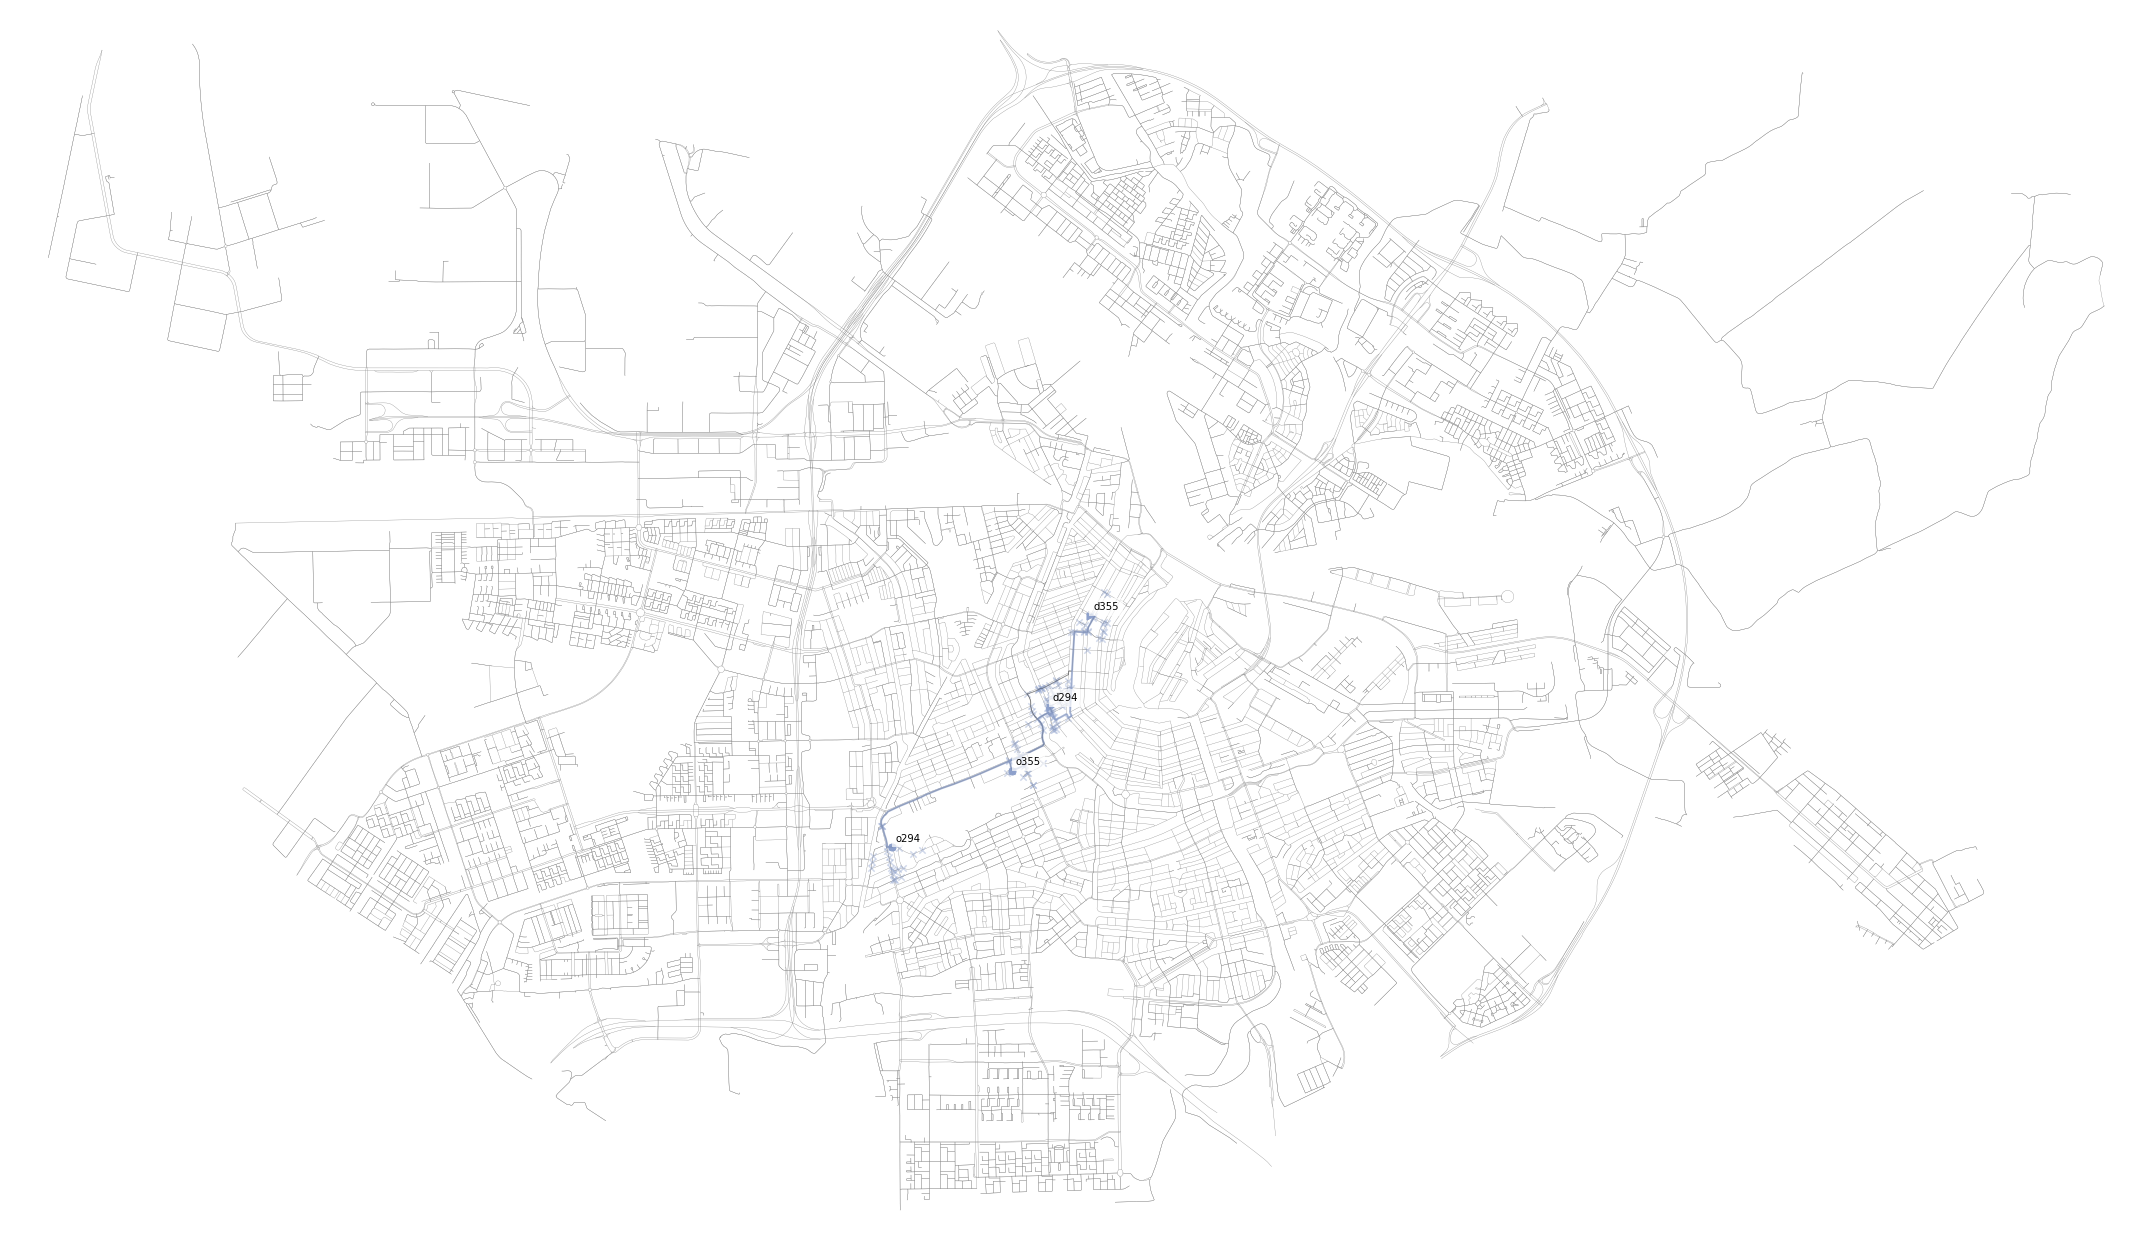

In [104]:
plot_map_rides(inData, [r['index']], light=False, pudo_path = False,  m_size=50, lw=2, fontsize = 10, figsize = (30,30))

0.04

In [ ]:
graph = ride_to_pudo_graph(r, inData)
lim = 10000
print(r)

# specific function assigned to specific ride degree
if len(r.indexes)==2:
    a = two_degree_pudo(graph, r, inData,params, alpha = 0.999, limit = 50000)

elif len(r.indexes)==3:                      
    a = three_degree_pudo(graph, r, inData,params, alpha = 0.95, limit = 20000)

elif len(r.indexes)==4:
    a = four_degree_pudo(graph, r, inData,params, alpha = 0.05, limit = 50000)
    
elif len(r.indexes)==5:
    a = five_degree_pudo(graph, r, inData,params, alpha = 0.05, limit = 50000)

In [121]:
a

,dist_v,tt_veh,tt_w,tt_b_a,ttrav_pudo,util_pudo
294,2155,269,386,30,655,7.5592
355,1725,215,458,30,673,8.0039


In [128]:
graph = ride_to_pudo_graph(r, inData)
lim = 10000
print(r)

# specific function assigned to specific ride degree
if len(r.indexes)==2:
    b = two_degree_pudo(graph, r, inData,params, alpha = 0.5, limit = 50000)

elif len(r.indexes)==3:                      
    b = three_degree_pudo(graph, r, inData,params, alpha = 0.1, limit = 20000)

elif len(r.indexes)==4:
    b = four_degree_pudo(graph, r, inData,params, alpha = 0.05, limit = 50000)
    
elif len(r.indexes)==5:
    b = five_degree_pudo(graph, r, inData,params, alpha = 0.05, limit = 50000)

indexes                                                   [294, 355]
u_pax                                                         8.8746
u_veh                                                            626
kind                                                              20
u_paxes                                  [4.749499999999999, 4.1251]
times                                        [3078.0, 279, 127, 205]
indexes_orig                                              [294, 355]
indexes_dest                                              [294, 355]
degree                                                             2
index                                                            831
lambda_r                                                  0.00318471
PassHourTrav_ns                                                  628
row                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
selected                                                           1
Name: 831, dtype: object
[inf, inf

In [133]:
b

,dist_v,tt_veh,tt_w,tt_b_a,ttrav_pudo,util_pudo
294,2615,327,50,30,377,4.1048
355,1828,229,458,30,687,8.1449


# All selected rides

PUDO optimisation takes place on all selected rides with degrees of three and higher, result is a large dataframe, used to be able to visualise PUDO paths

In [ ]:
r = inData.sblts.rides[inData.sblts.rides.degree!=1]
r = r[r.degree!=1]
r = r[r.selected == 1]

                                                       #last feasbile shared ride selected
r = r.iloc[30]
#r = r.loc[622]
#r = r.iloc[-8]
r

In [25]:
df = pd.DataFrame(columns =['index','indexes','u_veh','u_veh_pudo','veh_times','indexes_orig','PUDO_orig','indexes_dest','PUDO_dest','PassHourTrav_ns','degree'])

rides = inData.sblts.rides[inData.sblts.rides.degree!=1]
rides = rides[rides.selected == 1]
rides = rides.sample(2)

for index,r in rides.iterrows():
    graph = ride_to_pudo_graph(r,inData)
    if   len(r.indexes)==2:
        a = two_degree_pudo(graph,r,limit= 5000)
    elif len(r.indexes)==3:
        a = three_degree_pudo(graph,r, limit= 10000)
    elif len(r.indexes)==4:
        a = four_degree_pudo(graph,r, limit = 30000)
    elif len(r.indexes)==5:
        a = five_degree_pudo(graph,r, limit = 40000)
    
    veh_tt_i  = a[0]                                              # list of veh travel times
    walk_tt_i = a[1]                                              # list of walk tt
    a_e_tt_i  = a[2]                                              # list of a/e tt                   
    pudo_nodes= a[3]                                              # list of nodes
    
    veh_tt = sum(a[0])                                            # sum of list of veh travel times
    walk_tt= sum(a[1])
    a_e_tt = sum(a[2])
    
    vehhour  = veh_tt+a_e_tt                                      #total vehicle travel time is sum of travel times to nodes and sum of access egress times
    passhour = veh_tt+walk_tt+a_e_tt                              # passenger travel time is total vehicle travel time and sum of walking travel time and 

    pu_nodes  = pudo_nodes[:len(pudo_nodes)//2]
    do_nodes  = pudo_nodes[len(pudo_nodes)//2:]

    d = {'index':r['index'],
        'indexes': r.indexes,
        'u_veh':r.u_veh,
         'u_veh_pudo':vehhour,
        'veh_times':veh_tt_i,
         'walk_times': walk_tt_i,
         'board_alight_time': a_e_tt_i,
        'indexes_orig':r.indexes_orig,
        'PUDO_orig':pu_nodes,
        'indexes_dest':r.indexes_dest,
        'PUDO_dest':do_nodes,
        'PassHourTrav':int(passhour),
        'degree':len(r.indexes)}

    df = df.append(d,ignore_index=True)
df = df.set_index('index')

TypeError: two_degree_pudo() missing 2 required positional arguments: 'inData' and 'params'

In [104]:
a

[10.973899999999999, 16.85145, 10.3845]

In [38]:
df0 = df.iloc[-10]
df0

indexes                                          [50, 49, 80]
u_veh                                                    1097
u_veh_pudo                                                891
veh_times                             [134, 224, 164, 289, 0]
indexes_orig                                     [50, 49, 80]
PUDO_orig                  [46351127, 2021881815, 1106841180]
indexes_dest                                     [49, 50, 80]
PUDO_dest                      [46348779, 46345159, 46345159]
PassHourTrav_ns                                           NaN
degree                                                      3
PassHourTrav                                             2317
boarding/alighting_time               [20, 20, 20, 10, 10, 0]
walk_times                     [274, 297, 172, 266, 297, 120]
Name: 1801, dtype: object

In [ ]:
def tt_user(_r):
    indices = np.array(_r.indexes_orig+_r.indexes_dest)

    for i in range(_r.indexes):
        t_  = sum(_r.veh_times[np.where(indices==i)[0][0]:np.where(indices==i)[0][1]])
        w_  = _r.walk_times[np.where(indices==i)[0][0]]+_r.walk_times[np.where(indices==i)[0][1]]
        ttrav_sh_pudo = t_+w_

In [69]:
i = 50
indices = np.array(df0.indexes_orig+df0.indexes_dest)
t_list  = sum(df0.veh_times[np.where(indices==i)[0][0]:np.where(indices==i)[0][1]])
w_list  = df0.walk_times[np.where(indices==i)[0][0]]+df0.walk_times[np.where(indices==i)[0][1]]
ttrav_sh_pudo = t_list+w_list
ttrav_sh_pudo

1382

In [63]:
indices = np.array(df0.indexes_orig+df0.indexes_dest)
indices

array([50, 49, 80, 49, 50, 80], dtype=int64)

In [64]:
df0.walk_times[np.where(indices==80)[0][0]]+df0.walk_times[np.where(indices==80)[0][1]]

292

In [59]:
df0.veh_times[np.where(indeces==80)[0][0]:np.where(indeces==80)[0][1]]

[164, 289, 0]

In [ ]:
np.argwhere(np.diff(np.sign(y11 - y12))).flatten()

In [34]:
inData.sblts.rides_pudo = df

Positive results seen with TT. Essentially, the u_veh column represents the travel time of original exmas output while u_veh_pudo is with pudo optimisation. The latter only considers TT from pont to point and no idle/ waiting time is considered. 

At this stage PassHourTrav_ns = u_veh_pudo because walking time has not been implemented yet. I'm still examining possible approaches. 

